In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.metrics import classification_report
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import tqdm as tqdm

In [2]:
class_names=['balcony','corridor','kitchen','lobby','room']
class_names_labels={class_name:i for i, class_name in enumerate(class_names)}
nb_classes=len(class_names)
print(class_names_labels)
IMAGE_SIZE=[300,300]

{'balcony': 0, 'corridor': 1, 'kitchen': 2, 'lobby': 3, 'room': 4}


In [3]:
# loading data
def load_data():
    DIRECTORY=r"C:\Users\kumar\OneDrive\Desktop\ml\image_classifier\Datasets"
    CATEGORY=["train","test"]

    output=[]

    for category in CATEGORY:
        path=os.path.join(DIRECTORY,category);
        print(path)
        images=[]
        labels=[]

        print("Loading {}".format(category))

        for folder in os.listdir(path):
            label=class_names_labels[folder]

            # iterate over each image in the folder
            for file in os.listdir(os.path.join(path,folder)):
                
                # get the path name of the image
                img_path=os.path.join(os.path.join(path,folder),file)

                # open and resize the image
                image=cv2.imread(img_path)
                image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
                image=cv2.resize(image,IMAGE_SIZE)

                #append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
        
        images=np.array(images,dtype='float32')
        labels=np.array(labels,dtype='int32')

        output.append((images,labels))
    
    return output

In [4]:
(train_images,train_labels),(test_images,test_labels)=load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

C:\Users\kumar\OneDrive\Desktop\ml\image_classifier\Datasets\train
Loading train
C:\Users\kumar\OneDrive\Desktop\ml\image_classifier\Datasets\test
Loading test


In [5]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config=ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction=0.5
config.gpu_options.allow_growth=True
session=InteractiveSession(config=config)

In [6]:
from tensorflow.keras.layers import Input,Lambda,Dense,Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from glob import glob

In [7]:
vgg16=VGG16(input_shape=IMAGE_SIZE+[3],weights='imagenet',include_top=False)

In [8]:
for layer in vgg16.layers:
    layer.trainable=False

In [9]:
x=Flatten()(vgg16.output)

In [10]:
prediction=Dense(5,activation='softmax')(x)
model=Model(inputs=vgg16.input,outputs=prediction)

In [11]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 300, 300, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 300, 300, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 150, 150, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 150, 150, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 150, 150, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 75, 75, 128)       0     

In [12]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
history=model.fit(train_images,train_labels,epochs=4,validation_data=(test_images, test_labels))

Epoch 1/4


c:\Users\kumar\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\backend.py:5714: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


8/8 [==============================] - 104s 13s/step - loss: 2.7961 - accuracy: 0.3067 - val_loss: 1.9957 - val_accuracy: 0.4533
Epoch 2/4
8/8 [==============================] - 106s 14s/step - loss: 0.7977 - accuracy: 0.6933 - val_loss: 1.5792 - val_accuracy: 0.5200
Epoch 3/4
8/8 [==============================] - 102s 13s/step - loss: 0.4016 - accuracy: 0.8622 - val_loss: 1.2223 - val_accuracy: 0.6667
Epoch 4/4
8/8 [==============================] - 103s 13s/step - loss: 0.1734 - accuracy: 0.9511 - val_loss: 1.2206 - val_accuracy: 0.6800


3/3 - 25s - loss: 1.2206 - accuracy: 0.6800 - 25s/epoch - 8s/step


c:\Users\kumar\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


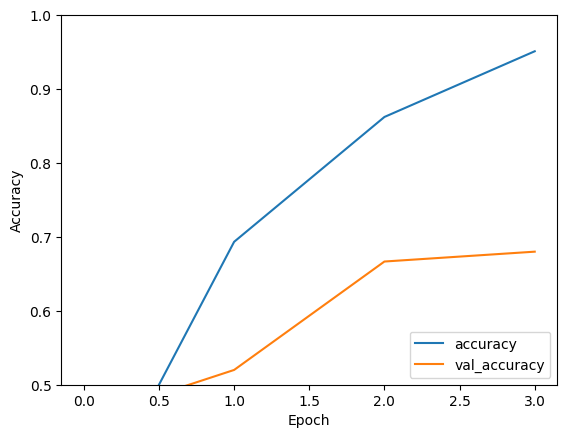

In [14]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

model.save("model.hdf5")

In [15]:
print(test_acc)

0.6800000071525574


In [16]:
# img=cv2.imread(r'C:\Users\kumar\OneDrive\Desktop\ml\image_classifier\hotel\test\balcony\Image_52.jpg');
# cv2.imshow("imag",img)
# cv2.waitKey(0)

In [17]:
y_pred = model.predict(test_images)
predicted_labels = np.argmax(y_pred, axis=1)

3/3 [==============================] - 26s 7s/step


In [18]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, predicted_labels)
print(cm)

[[13  2  0  0  0]
 [ 1 14  0  0  0]
 [ 1  0 14  0  0]
 [ 2  3  5  5  0]
 [ 6  3  1  0  5]]


In [19]:
cm_df = pd.DataFrame(cm,
                     index = ['balcony','corridor','kitchen','lobby','room'], 
                     columns = ['balcony','corridor','kitchen','lobby','room'])

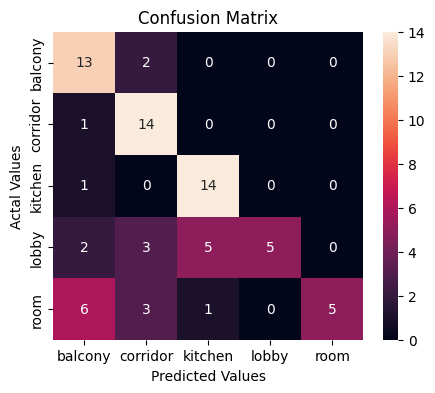

In [20]:
#Plotting the confusion matrix
import seaborn as sns
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [21]:
print(classification_report(test_labels,predicted_labels))

              precision    recall  f1-score   support

           0       0.57      0.87      0.68        15
           1       0.64      0.93      0.76        15
           2       0.70      0.93      0.80        15
           3       1.00      0.33      0.50        15
           4       1.00      0.33      0.50        15

    accuracy                           0.68        75
   macro avg       0.78      0.68      0.65        75
weighted avg       0.78      0.68      0.65        75



In [22]:
import gradio as gr

In [23]:
def predict_image(img):
  img_4d=img.reshape(-1,300,300,3)
  prediction=model.predict(img_4d)[0]
  return {class_names[i]: float(prediction[i]) for i in range(5)}

In [24]:
image = gr.inputs.Image(shape=(300,300))
label = gr.outputs.Label(num_top_classes=5)

gr.Interface(fn=predict_image, inputs=image, outputs=label,interpretation='default').launch(debug='True')

C:\Users\kumar\AppData\Local\Temp\ipykernel_9568\167277792.py:1: GradioDeprecationWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  image = gr.inputs.Image(shape=(300,300))
C:\Users\kumar\AppData\Local\Temp\ipykernel_9568\167277792.py:1: GradioDeprecationWarning: `optional` parameter is deprecated, and it has no effect
  image = gr.inputs.Image(shape=(300,300))
C:\Users\kumar\AppData\Local\Temp\ipykernel_9568\167277792.py:2: GradioDeprecationWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  label = gr.outputs.Label(num_top_classes=5)
C:\Users\kumar\AppData\Local\Temp\ipykernel_9568\167277792.py:2: GradioUnusedKwargWarning: You have unused kwarg parameters in Label, please remove them: {'type': 'auto'}
  label = gr.outputs.Label(num_top_classes=5)


Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.
